## Librerías

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

##  1. Cargar datos y definir ruta

In [2]:
# -----------------------------
# 1. Cargar datos y definir ruta
# -----------------------------

s2016_P = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2016_reducida.xlsx")
s2019_P = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2019_reducida.xlsx")
s2022_P = pd.read_excel(BASE_PATH / "BASE_SEGUIMIENTO_2022_reducida.xlsx")

## 2. Disciplinas alta demanda

In [3]:
disciplinas_alta_demanda = set([
    unidecode(d).strip().lower() for d in [
        "Informática Generalista", "Contaduría", "Ingeniería Industrial", "Estadística",
        "Desarrollo de Software", "Finanzas", "Diseño Gráfico", "Inglés",
        "Ingeniería Mecánica", "Ingeniería Electrónica", "Química", "Ingeniería de los Materiales",
        "Microbiología", "Administración", "Ingeniería Química", "Ecología", "Comercio Internacional",
        "Ciencias de la Computación", "Ingeniería del Software", "Ingeniería de Materiales"
    ]
])

## 3. Diccionario de mapeo

In [4]:
MAPEO_EQUIVALENCIAS = {
    "anio_graduacion": ["Año_graduacion", "AÑO"],
    "sexo": ["M2", "N2","N1"],
    "grado_academico": ["Grado", "GRADO"],
    "continua_estudios": ["Cont_estudios"],
    "relacion_estudios": ["A4", "B4"],
    "ingles": ["A5_1", "B5_1"],
    "frances": ["A5_2", "B5_2"],
    "portugues": ["A5_3", "B5_3"],
    "aleman": ["A5_4", "B5_4"],
    "italiano": ["A5_5", "B5_5"],
    "chino": ["A5_6", "B5_6"],
    "solo_espanol": ["A5_7", "B5_7"],  
    "satisf_u": ["A7", "A1","A2"],  
    "satisf_carrera": ["A11", "A6","A3"],
    "trabaja_durante_carr": ["B21", "C41","C5"],
    "trabaja_graduarse": ["C1", "D1"],
    "busc_trab_relac": ["C2", "D2"],
    "tiem_1trab_relac": ["C3", "D3"],   
    "trab_actual": ["D111", "E1"],
    "cant_empleos": ["D41", "E41"],
    "tipo_contrat": ["F1", "G51", "G4"],
    "puesto_trabajo": ["F7", "G13", "G10"],
    "carrera_graduo": ["F8_1", "G14_1", "G11_1"],
    "disponibilidad_horaria": ["F8_2", "G14_2", "G11_2"],
    "disponibilidad_residir": ["F8_3", "G14_3", "G11_3"],
    "espiritu_emprendedor": ["F8_4", "G14_4", "G11_4"],
    "experiencia_laboral": ["F8_5", "G14_5", "G11_5"],
    "grado_acad_influye": ["F8_6", "G14_6", "G11_6"],
    "lugar_residencia": ["F8_7", "G14_7", "G11_7"],
    "poseer_2do_idioma": ["F8_8", "G14_8", "G11_8"],
    "recomendacion_persona": ["F8_9", "G14_9", "G11_9"],   
    "universidad_graduo": ["F8_10", "G14_10", "G11_10"], 
    "ya_conocian": ["F8_11", "G14_11", "G11_11"],
    "pruebas_seleccion": ["F8_12", "G14_12", "G11_12"],
    "grado_relacion": ["G1", "H1"],
    "satisf_trab_actual": ["G5", "H5","H3"],
    "conoc_teoricos_1": ["H8_1_0", "G6a_1_0","H5_1_1"],
    "conoc_teoricos_2": ["G6a_1_1", "H8_1_1","H5_1_2"],
    "conoc_practicos_1": ["G6a_2_0", "H8_2_0","H5_2_1"],
    "conoc_practicos_2": ["G6a_2_1", "H8_2_1","H5_2_2"],
    "aprender_act_1": ["G6a_3_0", "H8_3_0","H5_3_1"],
    "aprender_act_2": ["G6a_3_1", "H8_3_1","H5_3_2"],
    "trabajo_equipo_1": ["G6a_4_0", "H8_4_0","H5_4_1"],
    "trabajo_equipo_2": ["G6a_4_1", "H8_4_1","H5_4_2"], 
    "prog_infor_bas_1": ["G6a_5_0", "H8_5_0","H5_5_1"], 
    "prog_infor_bas_2": ["G6a_5_1", "H8_5_1","H5_5_2"], 
    "redact_doc_inf_1": ["G6a_6_0", "H8_6_0","H5_6_1"], 
    "redact_doc_inf_2": ["G6a_6_1", "H8_6_1","H5_6_2"], 
    "expresar_verbal_1": ["G6a_7_0", "H8_7_0","H5_7_1"], 
    "expresar_verbal_2": ["G6a_7_1", "H8_7_1","H5_7_2"], 
    "hablar_publico_1": ["G6a_8_0", "H8_8_0","H5_8_1"],
    "hablar_publico_2": ["G6a_8_1", "H8_8_1","H5_8_2"],
    "tomar_decision_1": ["G6a_9_0", "H8_9_0","H5_9_1"],
    "tomar_decision_2": ["G6a_9_1", "H8_9_1","H5_9_2"],
    "manejo_ingles_1": ["G6a_10_0", "H8_10_0","H5_10_1"],
    "manejo_ingles_2": ["G6a_10_1", "H8_10_1","H5_10_2"],
    "investig_disc_1": ["G6a_11_0", "H8_11_0","H5_11_1"],
    "investig_disc_2": ["G6a_11_1", "H8_11_1","H5_11_2"],   
    "resolver_prob_1": ["G6a_12_0", "H8_12_0","H5_12_1"],
    "resolver_prob_2": ["G6a_12_1", "H8_12_1","H5_12_2"], 
    "creativ_innov_1": ["G6a_13_0", "H8_13_0","H5_13_1"],
    "creativ_innov_2": ["G6a_13_1", "H8_13_1","H5_13_2"],
    "software_espe_1": ["G6a_14_0", "H8_14_0","H5_14_1"],
    "software_espe_2": ["G6a_14_1", "H8_14_1","H5_14_2"],
    "trabajar_auton_1": ["H8_15_0", "H5_15_1"],
    "trabajar_auton_2": ["H8_15_1", "H5_15_2"],
    "etico_honestid_1": ["H8_16_0", "H5_16_1"],
    "etico_honestid_2": ["H8_16_1", "H5_16_2"],
    "tiempo_efectiva_1": ["H8_17_0", "H5_17_1"],
    "tiempo_efectiva_2": ["H8_17_1", "H5_17_2"],
    "compro_calidad_1": ["H8_18_0", "H5_18_1"],
    "compro_calidad_2": ["H8_18_1", "H5_18_2"],
    "formular_proyec_1": ["H8_19_0", "H5_19_1"],
    "formular_proyec_2": ["H8_19_1", "H5_19_2"],
    "adaptarse_sit_nuev_1": ["H8_20_0", "H5_20_1"],
    "adaptarse_sit_nuev_2": ["H8_20_1", "H5_20_2"],
    "analizar_data_nuev_1": ["H8_21_0", "H5_21_1"],
    "analizar_data_nuev_2": ["H8_21_1", "H5_21_2"],
    "pensamiento_critic_1": ["H8_22_0", "H5_22_1"],
    "pensamiento_critic_2": ["H8_22_1", "H5_22_2"],
    "necesidades_atencion_1": ["H8_23_0", "H5_23_1"],
    "necesidades_atencion_2": ["H8_23_1", "H5_23_2"],
    "analisis_sintesis_1": ["H8_24_0", "H5_24_1"],
    "analisis_sintesis_2": ["H8_24_1", "H5_24_2"],
    "trab_bajo_presion_1": ["H8_25_0", "H5_25_1"],
    "trab_bajo_presion_2": ["H8_25_1", "H5_25_2"],
    "bases_progama_1": ["H5_26_1"],
    "bases_progama_2": ["H5_26_2"],
    "estado_civil": ["M31","N31","N21"],
    "residencia_actual": ["M7","N8","N7_PROVINCIA"],
    "edad_actual": ["EDAD","EDAD_REC"],
    "edad_graduacion": ["EDADGRAD","EDADGRAD_REC"],
    "nivel_educativo_ambos": ["edu_proge"],   
    "condicion_laboral_conjunt": ["LABORAL"],
    "relacion_estudio_trabajo": ["RELACION"],
    "tipo_trabajo": ["TIPO_TRAB"],
    "disciplina": ["Disciplina"],    
    "ingresos": ["INGRESO_FINAL", "INGRESOS"],
}

## Función estandarizadora

In [7]:
# -----------------------------
# 4. Función estandarizadora
# -----------------------------
def estandarizar_dataset(df, año, mapeo):
    df = df.copy()
    renombre = {}
    for col_estandar, variantes in mapeo.items():
        for v in variantes:
            if v in df.columns:
                renombre[v] = col_estandar
                break
    df = df.rename(columns=renombre)
    df["año_encuesta"] = año
    return df

s2016_P = estandarizar_dataset(s2016_P, 2016, MAPEO_EQUIVALENCIAS)
s2019_P = estandarizar_dataset(s2019_P, 2019, MAPEO_EQUIVALENCIAS)
s2022_P = estandarizar_dataset(s2022_P, 2022, MAPEO_EQUIVALENCIAS)


## Unificación

In [8]:
# Unificación
df_P = pd.concat([s2016_P, s2019_P, s2022_P], ignore_index=True)

In [10]:
# Guardar CSV del DataFrame unificado
df_P.to_csv("df_unificado_PCA.csv", index=False, encoding="utf-8-sig")


## Codificar y validar

In [13]:
import pandas as pd
import numpy as np
from unidecode import unidecode

# Cargar el CSV unificado
df_P = pd.read_csv("df_unificado_PCA.csv")

# Set de disciplinas de alta demanda
disciplinas_alta_demandas = set([
    unidecode(d).strip().lower() for d in [
        "Informática Generalista", "Contaduría", "Ingeniería Industrial", "Estadística",
        "Desarrollo de Software", "Finanzas", "Diseño Gráfico", "Inglés",
        "Ingeniería Mecánica", "Ingeniería Electrónica", "Química", "Ingeniería de los Materiales",
        "Microbiología", "Administración", "Ingeniería Química", "Ecología", "Comercio Internacional",
        "Ciencias de la Computación", "Ingeniería del Software", "Ingeniería de Materiales"
    ]
])

# ------------------------------------
# Funciones para codificar y validar
# ------------------------------------
def codificar_empleo(val):
    if pd.isna(val): return np.nan
    val = str(val).strip().lower()
    if val in ["asalariado", "independiente"]:
        return 1
    elif val in ["desempleado", "inactivo"]:
        return 0
    return np.nan

def validar_disciplina(val):
    if pd.isna(val): return np.nan
    val = unidecode(str(val)).strip().lower()
    return val if val in disciplinas_alta_demandas else np.nan

# ------------------------------------
# Aplicar transformaciones
# ------------------------------------
# Codificación de columnas clave
df_P["empleado"] = df_P["tipo_trabajo"].apply(codificar_empleo)
df_P["disciplina"] = df_P["disciplina"].apply(validar_disciplina)
df_P["años_post_graduacion"] = df_P["año_encuesta"] - df_P["anio_graduacion"]

# Crear variable experiencia_previa
if "experiencia_laboral_previa" in df_P.columns:
    df_P["experiencia_previa"] = df_P["experiencia_laboral_previa"].apply(
        lambda x: 1 if str(x).strip().lower() in ["si", "sí", "1", "true"] 
        else 0 if str(x).strip().lower() in ["no", "0", "false"] 
        else np.nan
    )
else:
    df_P["experiencia_previa"] = np.where(
        df_P["trabaja_graduarse"].isin([
            "Tenía trabajo relacionado con la carrera",
            "Tenía trabajo, pero no estaba relacionado con la carrera"
        ]) |
        df_P["trabaja_durante_carr"].astype(str).str.lower().isin(["sí", "si", "sí."]),
        1, 0
    )

# ------------------------------------
# Guardar para continuar
# ------------------------------------
df_P.to_csv("df_procesado_PCA.csv", index=False, encoding="utf-8-sig")


Varianza explicada por el Componente 1: 11.66%
Varianza explicada por el Componente 2: 3.74%
Varianza total explicada: 15.40%


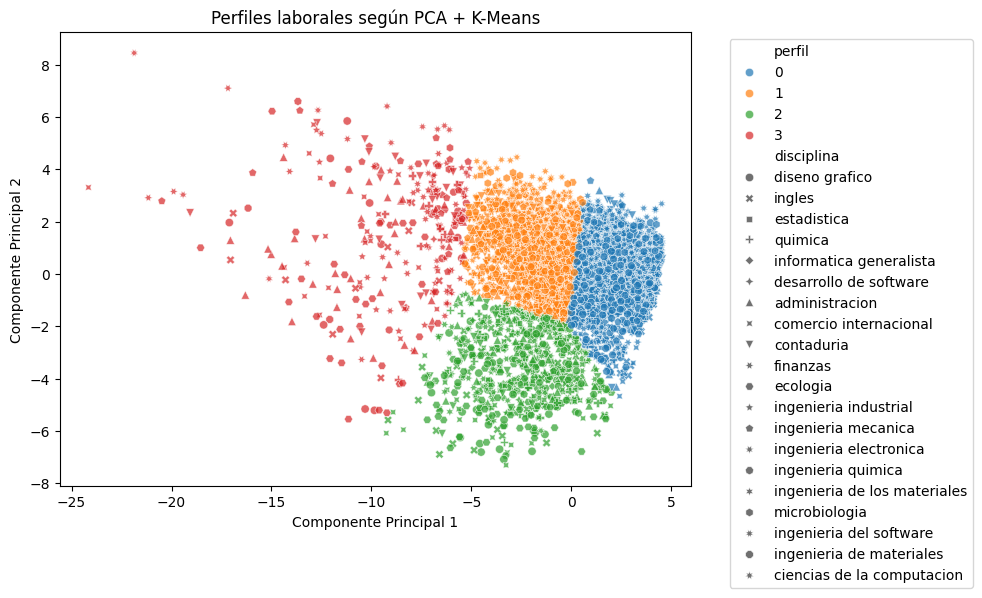

Contribución de las variables a los componentes principales:
                           PC1       PC2
resolver_prob_2       0.217272 -0.034395
tomar_decision_2      0.214667 -0.047875
analisis_sintesis_2   0.210966 -0.116672
pensamiento_critic_2  0.208058 -0.132489
creativ_innov_2       0.206423 -0.011434
conoc_practicos_2     0.205393  0.164988
aprender_act_2        0.204427  0.072027
expresar_verbal_2     0.202871 -0.073006
analizar_data_nuev_2  0.202114 -0.095012
formular_proyec_2     0.201017 -0.086694


In [30]:
# ========================
# 1. Cargar librerías
# ========================
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# 2. Cargar datos
# ========================
df = pd.read_csv("df_procesado_PCA.csv")

# ========================
# 3. Filtrar solo personas empleadas
# ========================
df_empleados = df[df['empleado'] == 1].copy()

# ========================
# 4. Seleccionar variables explicativas (modifica según tu dataset)
# ========================
variables_explicativas = [
     "anio_graduacion", "sexo", "grado_academico", "satisf_u","satisf_carrera", "tiem_1trab_relac", 
    "trab_actual", "grado_relacion", 
    "satisf_trab_actual", "conoc_teoricos_2", "conoc_practicos_2",
    "aprender_act_2", "trabajo_equipo_2", "prog_infor_bas_2", 
    "redact_doc_inf_2", "expresar_verbal_2", "hablar_publico_2",
    "tomar_decision_2", "manejo_ingles_2", "investig_disc_2", 
    "resolver_prob_2",  "creativ_innov_2", "software_espe_2", 
    "trabajar_auton_2", "etico_honestid_2", "tiempo_efectiva_2", "compro_calidad_2", 
    "formular_proyec_2", "adaptarse_sit_nuev_2", 
    "analizar_data_nuev_2", "pensamiento_critic_2", "necesidades_atencion_2", 
    "analisis_sintesis_2", "trab_bajo_presion_2", "bases_progama_2", 
    "estado_civil", "residencia_actual", "edad_actual", "edad_graduacion", "nivel_educativo_ambos", "condicion_laboral_conjunt", 
    "relacion_estudio_trabajo", "tipo_trabajo", "disciplina", "ingresos"
]

df_pca = df_empleados[variables_explicativas].copy()

# ========================
# 5. Convertir variables categóricas a dummies
# ========================
df_pca = pd.get_dummies(df_pca, drop_first=True)

# ========================
# 6. Imputar valores faltantes
# ========================
imputer = SimpleImputer(strategy='mean')
df_imputado = pd.DataFrame(imputer.fit_transform(df_pca), columns=df_pca.columns)

# ========================
# 7. Estandarizar
# ========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputado)

# ========================
# 8. PCA
# ========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca_result = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Mostrar la proporción de varianza explicada
explained_variance = pca.explained_variance_ratio_

print(f"Varianza explicada por el Componente 1: {explained_variance[0]*100:.2f}%")
print(f"Varianza explicada por el Componente 2: {explained_variance[1]*100:.2f}%")
print(f"Varianza total explicada: {sum(explained_variance)*100:.2f}%")


# ========================
# 9. Clustering KMeans para perfiles (elige número de clústeres)
# ========================
kmeans = KMeans(n_clusters=4, random_state=42)
df_pca_result['perfil'] = kmeans.fit_predict(X_pca)

# Opcional: agregar disciplina para visualización
df_pca_result['disciplina'] = df_empleados['disciplina'].values

# ========================
# 10. Visualización
# ========================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca_result,
    x='PC1', y='PC2',
    hue='perfil', palette='tab10',
    style='disciplina', alpha=0.7
)
plt.title('Perfiles laborales según PCA + K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ========================
# 11. Interpretar componentes (opcional)
# ========================
componentes = pd.DataFrame(
    pca.components_,
    columns=df_imputado.columns,
    index=['PC1', 'PC2']
).T

print("Contribución de las variables a los componentes principales:")
print(componentes.sort_values(by='PC1', key=abs, ascending=False).head(10))


## Código para caracterizar cada clúster con variables cualitativas

In [22]:
# 1. Agregar variables de interés al DataFrame con resultados del PCA
df_pca_result['sexo'] = df_empleados['sexo'].values
df_pca_result['disciplina'] = df_empleados['disciplina'].values
df_pca_result['grado_academico'] = df_empleados['grado_academico'].values
df_pca_result['tipo_trabajo'] = df_empleados['tipo_trabajo'].values
df_pca_result['ingresos'] = df_empleados['ingresos'].values


In [24]:
# Calcular solo la media de ingresos por perfil
media_ingresos = df_pca_result.groupby('perfil')['ingresos'].mean().round(2)
print(media_ingresos)

perfil
0    938035.08
1    941040.53
2    855686.39
3    894397.64
Name: ingresos, dtype: float64


In [20]:
# Por SEXO
sexo_cluster = df_pca_result.groupby(['perfil', 'sexo']).size().unstack(fill_value=0)

# Por DISCIPLINA
disciplina_cluster = df_pca_result.groupby(['perfil', 'disciplina']).size().unstack(fill_value=0)

# Por GRADO ACADÉMICO
grado_cluster = df_pca_result.groupby(['perfil', 'grado_academico']).size().unstack(fill_value=0)

# Por TIPO DE TRABAJO
tipo_trabajo_cluster = df_pca_result.groupby(['perfil', 'tipo_trabajo']).size().unstack(fill_value=0)


In [21]:
# Mostrar tablas
print("Distribución por SEXO:")
print(sexo_cluster)

print("\nDistribución por DISCIPLINA:")
print(disciplina_cluster)

print("\nDistribución por GRADO ACADÉMICO:")
print(grado_cluster)

print("\nDistribución por TIPO DE TRABAJO:")
print(tipo_trabajo_cluster)

# (Opcional) Exportar a CSV
sexo_cluster.to_csv("cluster_por_sexo.csv")
disciplina_cluster.to_csv("cluster_por_disciplina.csv")
grado_cluster.to_csv("cluster_por_grado.csv")
tipo_trabajo_cluster.to_csv("cluster_por_tipo_trabajo.csv")


Distribución por SEXO:
sexo    Hombre  Mujer
perfil               
0         2006   1622
1         1175    769
2          269    383
3          166    129

Distribución por DISCIPLINA:
disciplina  administracion  ciencias de la computacion  \
perfil                                                   
0                      435                         101   
1                      269                          49   
2                       65                           0   
3                       43                           3   

disciplina  comercio internacional  contaduria  desarrollo de software  \
perfil                                                                   
0                              185         431                      84   
1                              125         207                      53   
2                               94          35                       8   
3                               30          27                       1   

disciplina  diseno gr

🟠 Perfil 1 – Profesional joven, administrativo y consolidado
Este grupo también es significativo en tamaño y presenta una mayor proporción de hombres (60%) que mujeres (40%). Las disciplinas predominantes son:

Administración, contaduría, finanzas y diseño gráfico, acompañadas por una representación notable de ingeniería industrial y del software.

En términos de formación, el 53% cuenta con bachillerato y el 47% con licenciatura, evidenciando una preparación académica intermedia-alta. El tipo de trabajo es predominantemente asalariado (90%), lo que sugiere inserción en empleos formales, probablemente en áreas administrativas, financieras o de servicios profesionales.

Este perfil es el que reporta el mayor ingreso promedio mensual: ₡941.040, lo que puede estar asociado a puestos de mando medio, gestión, análisis financiero, diseño y consultoría, donde la experiencia y habilidades blandas pesan tanto como el grado académico.

En síntesis, este perfil representa a personas profesionales consolidadas, que han alcanzado ingresos competitivos sin necesariamente tener una formación técnica dura, pero sí relevante para el mercado laboral.

🟢 Perfil 2 – Emergente, femenino, de orientación humanista y en construcción
Este clúster se caracteriza por tener una mayor proporción de mujeres (59%), siendo el único donde el sexo femenino es mayoritario. Las disciplinas más representadas son:

Ecología, comercio internacional, química, microbiología e idiomas (como inglés).

Desde el punto de vista académico, este es el perfil con menor proporción de personas con licenciatura: solo un 24% ha alcanzado ese nivel, mientras que el 76% cuenta con bachillerato universitario. Esto puede indicar un acceso más limitado a estudios avanzados, ya sea por razones económicas, institucionales o personales.

En relación con el tipo de empleo, la mayoría son asalariados (83%), pero hay una presencia mayor de trabajo independiente (17%) en comparación con otros grupos. Esto puede sugerir trayectorias laborales más flexibles, informales o en sectores menos estructurados.

Este es el perfil con el ingreso mensual promedio más bajo: ₡855.686, lo cual refuerza la hipótesis de que muchas personas en este grupo trabajan en ocupaciones con menor retorno económico, menor estabilidad o con sobrecalificación respecto a su disciplina.

En síntesis, este perfil representa a profesionales emergentes o en transición, predominantemente mujeres, con formación en disciplinas de menor absorción laboral y con ingresos más bajos, a pesar de su preparación.

🔴 Perfil 3 – Heterogéneo, reducido y en transición laboral
Este es el grupo más pequeño en número y presenta una distribución de sexo ligeramente mayor en hombres (56%). Es un clúster heterogéneo en disciplinas, con representación baja pero diversa en áreas como:

Ecología, inglés, ingeniería mecánica, administración y diseño gráfico.

En cuanto a nivel educativo, 67% tiene bachillerato y solo 33% licenciatura, lo que lo convierte en uno de los grupos con menor nivel educativo formal. No obstante, su ingreso promedio mensual es de ₡894.398, superior al perfil 2, lo cual es interesante dado su menor nivel académico y su menor tamaño.

Esto sugiere que algunas personas en este grupo han accedido a puestos bien remunerados a pesar de condiciones formales menos ventajosas, lo cual podría deberse a factores como experiencia previa, redes de contacto, emprendimientos personales o habilidades no académicas.

El tipo de empleo es predominantemente asalariado (89%), pero también incluye una proporción de trabajo independiente (11%).

En síntesis, este perfil representa a un grupo mixto, de trayectorias menos lineales, que puede incluir tanto casos exitosos sin alta formación académica como personas en empleos intermedios. Su heterogeneidad lo hace menos interpretable, pero valioso para identificar casos atípicos o perfiles resilientes.



| Perfil | Sexo dominante | Disciplinas destacadas           | Ingreso medio ₡ | Característica clave            |
| ------ | -------------- | -------------------------------- | --------------- | ------------------------------- |
| 0      | Hombres (55%)  | Ingeniería, finanzas, contaduría | ₡938.035        | Técnico-formal con alta demanda |
| 1      | Hombres (60%)  | Administración, diseño gráfico   | ₡941.041        | Administrativo consolidado      |
| 2      | Mujeres (59%)  | Ecología, idiomas, química       | ₡855.686        | Emergente y vulnerable          |
| 3      | Hombres (56%)  | Mixto, bajo volumen              | ₡894.398        | Heterogéneo con potencial       |


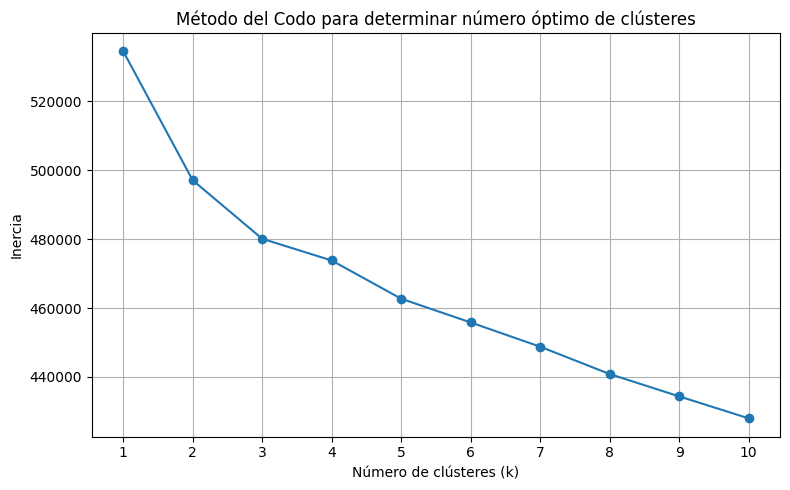

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Rango de valores de k que se van a probar
k_range = range(1, 11)

# Lista para guardar la inercia (distancia dentro del clúster)
inertias = []

# Calcular la inercia para cada valor de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Método del Codo para determinar número óptimo de clústeres')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.show()


Varianza explicada por el Componente 1: 11.66%


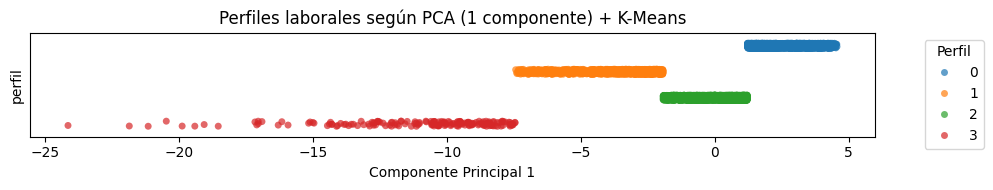

Contribución de las variables al único componente principal:
                           PC1
resolver_prob_2       0.217272
tomar_decision_2      0.214667
analisis_sintesis_2   0.210966
pensamiento_critic_2  0.208058
creativ_innov_2       0.206423
conoc_practicos_2     0.205393
aprender_act_2        0.204427
expresar_verbal_2     0.202871
analizar_data_nuev_2  0.202114
formular_proyec_2     0.201017


In [32]:
# ========================
# 8. PCA con un solo componente
# ========================
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Convertir el resultado en un DataFrame con solo una columna
df_pca_result = pd.DataFrame(X_pca, columns=['PC1'])

# Mostrar la proporción de varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por el Componente 1: {explained_variance[0]*100:.2f}%")

# ========================
# 9. Clustering KMeans con una sola dimensión
# ========================
kmeans = KMeans(n_clusters=4, random_state=42)
df_pca_result['perfil'] = kmeans.fit_predict(X_pca)

# Agregar disciplina para análisis posterior
df_pca_result['disciplina'] = df_empleados['disciplina'].values

# ========================
# 10. Visualización en 1D
# ========================
plt.figure(figsize=(10, 2))
sns.stripplot(
    data=df_pca_result,
    x='PC1', y='perfil',
    hue='perfil',
    palette='tab10',
    alpha=0.7,
    jitter=True,
    orient='h'
)
plt.title('Perfiles laborales según PCA (1 componente) + K-Means')
plt.xlabel('Componente Principal 1')
plt.yticks([])
plt.legend(title='Perfil', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ========================
# 11. Interpretar componentes (único componente)
# ========================
componentes = pd.DataFrame(
    pca.components_,
    columns=df_imputado.columns,
    index=['PC1']
).T

print("Contribución de las variables al único componente principal:")
print(componentes.sort_values(by='PC1', key=abs, ascending=False).head(10))


In [33]:
# 1. Agregar variables de interés al DataFrame con resultados del PCA
df_pca_result['sexo'] = df_empleados['sexo'].values
df_pca_result['disciplina'] = df_empleados['disciplina'].values
df_pca_result['grado_academico'] = df_empleados['grado_academico'].values
df_pca_result['tipo_trabajo'] = df_empleados['tipo_trabajo'].values
df_pca_result['ingresos'] = df_empleados['ingresos'].values


In [34]:
# Calcular solo la media de ingresos por perfil
media_ingresos = df_pca_result.groupby('perfil')['ingresos'].mean().round(2)
print(media_ingresos)

perfil
0    936983.66
1    912172.09
2    932633.10
3    854041.42
Name: ingresos, dtype: float64


In [35]:
# Mostrar tablas
print("Distribución por SEXO:")
print(sexo_cluster)

print("\nDistribución por DISCIPLINA:")
print(disciplina_cluster)

print("\nDistribución por GRADO ACADÉMICO:")
print(grado_cluster)

print("\nDistribución por TIPO DE TRABAJO:")
print(tipo_trabajo_cluster)

# (Opcional) Exportar a CSV
sexo_cluster.to_csv("cluster_por_sexo.csv")
disciplina_cluster.to_csv("cluster_por_disciplina.csv")
grado_cluster.to_csv("cluster_por_grado.csv")
tipo_trabajo_cluster.to_csv("cluster_por_tipo_trabajo.csv")

Distribución por SEXO:
sexo    Hombre  Mujer
perfil               
0         2006   1622
1         1175    769
2          269    383
3          166    129

Distribución por DISCIPLINA:
disciplina  administracion  ciencias de la computacion  \
perfil                                                   
0                      435                         101   
1                      269                          49   
2                       65                           0   
3                       43                           3   

disciplina  comercio internacional  contaduria  desarrollo de software  \
perfil                                                                   
0                              185         431                      84   
1                              125         207                      53   
2                               94          35                       8   
3                               30          27                       1   

disciplina  diseno gr